In [ ]:
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.6 MB/s eta 0:00:00


In [ ]:
import einops
import mediapy
import matplotlib.pyplot as plt
import torch
import torchvision
import tqdm
import torchvision.transforms.functional as TF
import random
import math
import gc
from torchvision import datasets, transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
      self.bn = nn.BatchNorm2d(out_channels)
      self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.conv(x)
      x = self.bn(x)
      x = self.activation(x)
      return x


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
      self.bn = nn.BatchNorm2d(out_channels)
      self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.conv(x)
      x = self.bn(x)
      x = self.activation(x)
      return x


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
      self.bn = nn.BatchNorm2d(out_channels)
      self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.conv(x)
      x = self.bn(x)
      x = self.activation(x)
      return x


class Flatten(nn.Module):
    def __init__(self):
      super().__init__()
      self.pool = nn.AvgPool2d(kernel_size=7)
      self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.pool(x)
      x = self.activation(x)
      return x


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
      super().__init__()
      self.upsample = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=7,
            stride=1,
            padding=0
      )
      self.bn = nn.BatchNorm2d(in_channels)
      self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.upsample(x)
      x = self.bn(x)
      x = self.activation(x)
      return x


class Concat(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, *inputs: torch.Tensor) -> torch.Tensor:
    return torch.cat(inputs, dim=1)


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.conv1 = Conv(in_channels, out_channels)
      self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.conv1(x)
      x = self.conv2(x)
      return x


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.down = DownConv(in_channels, out_channels)
      self.conv = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.down(x)
      x = self.conv(x)
      return x


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.up = UpConv(in_channels, out_channels)
      self.conv = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.up(x)
      x = self.conv(x)
      return x

## Implementing Unconditional UNet

In [ ]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
      super().__init__()
      self.conv1 = ConvBlock(in_channels, num_hiddens)
      self.down1 = DownBlock(num_hiddens, num_hiddens)
      self.down2 = DownBlock(num_hiddens, 2 * num_hiddens)
      self.flatten = Flatten()
      self.unflatten = Unflatten(2 * num_hiddens)
      self.up1 = UpBlock(4 * num_hiddens, num_hiddens)
      self.up2 = UpBlock(2 * num_hiddens, num_hiddens)
      self.conv2 = ConvBlock(2 * num_hiddens, num_hiddens)
      self.conv3 = nn.Conv2d(num_hiddens, in_channels, 3, 1, 1)
      self.concat = Concat()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

      x = self.conv1(x)
      a = x.clone()
      x = self.down1(x)
      b = x.clone()
      x = self.down2(x)
      c = x.clone()
      x = self.flatten(x)
      x = self.unflatten(x)
      x = self.concat(x, c)
      x = self.up1(x)
      x = self.concat(x, b)
      x = self.up2(x)
      x = self.concat(x, a)
      x = self.conv2(x)
      x = self.conv3(x)
      gc.collect()
      return x

In [ ]:
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.88MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [ ]:
unet = UnconditionalUNet(1, 128)
unet = unet.cuda()
criterion = nn.MSELoss() # CrossEntropyLoss(), L1loss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.0001)

  9%|▊         | 20/235 [00:08<01:19,  2.69it/s]

[1,    20] loss: 0.098


 17%|█▋        | 40/235 [00:16<01:12,  2.69it/s]

[1,    40] loss: 0.031


 26%|██▌       | 60/235 [00:24<01:06,  2.65it/s]

[1,    60] loss: 0.019


 34%|███▍      | 80/235 [00:31<01:01,  2.53it/s]

[1,    80] loss: 0.017


 43%|████▎     | 100/235 [00:39<00:56,  2.37it/s]

[1,   100] loss: 0.015


 51%|█████     | 120/235 [00:47<00:44,  2.58it/s]

[1,   120] loss: 0.015


 60%|█████▉    | 140/235 [00:55<00:38,  2.45it/s]

[1,   140] loss: 0.014


 68%|██████▊   | 160/235 [01:03<00:30,  2.50it/s]

[1,   160] loss: 0.014


 77%|███████▋  | 180/235 [01:11<00:22,  2.47it/s]

[1,   180] loss: 0.013


 85%|████████▌ | 200/235 [01:20<00:14,  2.36it/s]

[1,   200] loss: 0.013


 94%|█████████▎| 220/235 [01:28<00:06,  2.43it/s]

[1,   220] loss: 0.013


  9%|▊         | 20/235 [00:08<01:31,  2.35it/s]

[2,    20] loss: 0.012


 17%|█▋        | 40/235 [00:16<01:22,  2.36it/s]

[2,    40] loss: 0.012


 26%|██▌       | 60/235 [00:25<01:15,  2.33it/s]

[2,    60] loss: 0.012


 34%|███▍      | 80/235 [00:34<01:07,  2.30it/s]

[2,    80] loss: 0.011


 43%|████▎     | 100/235 [00:42<00:57,  2.36it/s]

[2,   100] loss: 0.011


 51%|█████     | 120/235 [00:51<00:48,  2.38it/s]

[2,   120] loss: 0.011


 60%|█████▉    | 140/235 [00:59<00:40,  2.37it/s]

[2,   140] loss: 0.011


 68%|██████▊   | 160/235 [01:07<00:31,  2.39it/s]

[2,   160] loss: 0.011


 77%|███████▋  | 180/235 [01:16<00:23,  2.38it/s]

[2,   180] loss: 0.010


 85%|████████▌ | 200/235 [01:24<00:14,  2.37it/s]

[2,   200] loss: 0.010


 94%|█████████▎| 220/235 [01:33<00:06,  2.32it/s]

[2,   220] loss: 0.010


  9%|▊         | 20/235 [00:08<01:32,  2.33it/s]

[3,    20] loss: 0.010


 17%|█▋        | 40/235 [00:17<01:22,  2.35it/s]

[3,    40] loss: 0.010


 26%|██▌       | 60/235 [00:25<01:13,  2.37it/s]

[3,    60] loss: 0.010


 34%|███▍      | 80/235 [00:34<01:05,  2.36it/s]

[3,    80] loss: 0.010


 43%|████▎     | 100/235 [00:42<00:57,  2.35it/s]

[3,   100] loss: 0.010


 51%|█████     | 120/235 [00:51<00:48,  2.38it/s]

[3,   120] loss: 0.009


 60%|█████▉    | 140/235 [00:59<00:40,  2.37it/s]

[3,   140] loss: 0.009


 68%|██████▊   | 160/235 [01:08<00:32,  2.31it/s]

[3,   160] loss: 0.009


 77%|███████▋  | 180/235 [01:16<00:23,  2.36it/s]

[3,   180] loss: 0.009


 85%|████████▌ | 200/235 [01:25<00:14,  2.36it/s]

[3,   200] loss: 0.009


 94%|█████████▎| 220/235 [01:33<00:06,  2.34it/s]

[3,   220] loss: 0.009


  9%|▊         | 20/235 [00:08<01:30,  2.37it/s]

[4,    20] loss: 0.009


 17%|█▋        | 40/235 [00:17<01:24,  2.31it/s]

[4,    40] loss: 0.009


 26%|██▌       | 60/235 [00:25<01:14,  2.36it/s]

[4,    60] loss: 0.009


 34%|███▍      | 80/235 [00:34<01:05,  2.36it/s]

[4,    80] loss: 0.009


 43%|████▎     | 100/235 [00:42<00:58,  2.33it/s]

[4,   100] loss: 0.009


 51%|█████     | 120/235 [00:51<00:48,  2.35it/s]

[4,   120] loss: 0.009


 60%|█████▉    | 140/235 [00:59<00:40,  2.35it/s]

[4,   140] loss: 0.009


 68%|██████▊   | 160/235 [01:08<00:31,  2.35it/s]

[4,   160] loss: 0.009


 77%|███████▋  | 180/235 [01:16<00:23,  2.31it/s]

[4,   180] loss: 0.009


 85%|████████▌ | 200/235 [01:25<00:14,  2.35it/s]

[4,   200] loss: 0.009


 94%|█████████▎| 220/235 [01:34<00:06,  2.35it/s]

[4,   220] loss: 0.009


  9%|▊         | 20/235 [00:08<01:31,  2.36it/s]

[5,    20] loss: 0.009


 17%|█▋        | 40/235 [00:17<01:22,  2.36it/s]

[5,    40] loss: 0.008


 26%|██▌       | 60/235 [00:25<01:16,  2.28it/s]

[5,    60] loss: 0.009


 34%|███▍      | 80/235 [00:34<01:05,  2.36it/s]

[5,    80] loss: 0.009


 43%|████▎     | 100/235 [00:42<00:57,  2.35it/s]

[5,   100] loss: 0.008


 51%|█████     | 120/235 [00:51<00:49,  2.33it/s]

[5,   120] loss: 0.008


 60%|█████▉    | 140/235 [00:59<00:40,  2.35it/s]

[5,   140] loss: 0.008


 68%|██████▊   | 160/235 [01:08<00:31,  2.35it/s]

[5,   160] loss: 0.008


 77%|███████▋  | 180/235 [01:16<00:23,  2.35it/s]

[5,   180] loss: 0.008


 85%|████████▌ | 200/235 [01:25<00:14,  2.36it/s]

[5,   200] loss: 0.008


 94%|█████████▎| 220/235 [01:33<00:06,  2.35it/s]

[5,   220] loss: 0.008


100%|██████████| 235/235 [01:40<00:00,  2.35it/s]


finished training


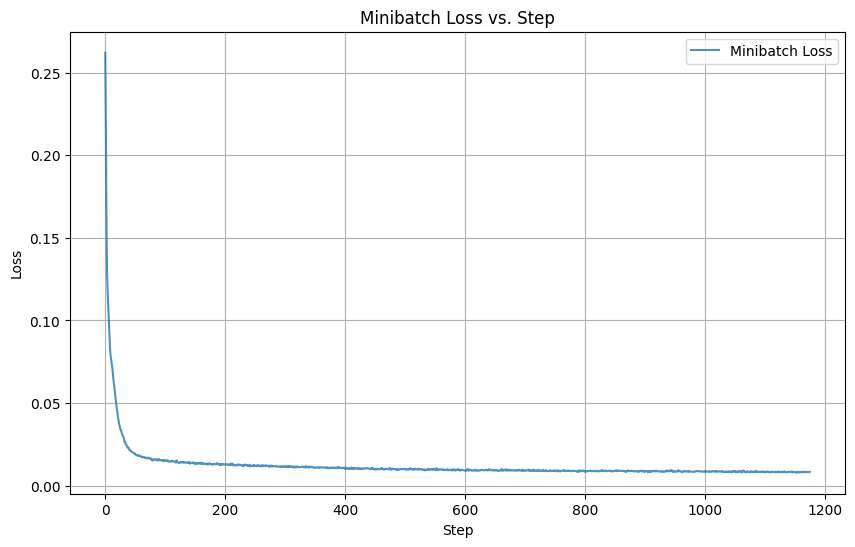

In [ ]:
num_epochs = 5
sigma = 0.5
losses = []
steps = []
step_counter = 0

for epoch in range(num_epochs):
  running_loss = 0

  progress_bar = tqdm.tqdm(train_loader)

  for i, data in enumerate(progress_bar):
    clean_images, _ = data # labels not used here

    clean_images = clean_images.cuda()

    epsilon = torch.randn_like(clean_images)
    noised_images = clean_images + (epsilon * sigma)

    # Forward pass
    noised_images = noised_images.cuda()
    optimizer.zero_grad()
    outputs = unet(noised_images)

    # Calculate loss
    loss = criterion(outputs, clean_images)
    loss.backward()
    optimizer.step()

    item = loss.item()
    running_loss += item
    losses.append(item)

    steps.append(step_counter)
    step_counter += 1

    if i % 20 == 19:    # print every 20 minibatches
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
        running_loss = 0.0

print("finished training")
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, label='Minibatch Loss', alpha=0.8)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Minibatch Loss vs. Step')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
torch.save(unet.state_dict(), './checkpoint.pt')
state_dict = torch.load('./checkpoint.pt')
unet.load_state_dict(state_dict)

<ipython-input-10-697ffc0106f8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./checkpoint.pt')


<All keys matched successfully>

In [ ]:
clean_test_images, _ = next(iter(test_loader))
clean_test_images = clean_test_images[:16]

clean_test_display = [img.permute(1, 2, 0).cpu() / 2. + 0.5 for img in clean_test_images]

mediapy.show_images(
        clean_test_display,
        columns=4,  # Show 4 images per row
        height=200  # Height of each image
    )

sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

for sigma in sigmas:
  epsilon = torch.randn_like(clean_test_images)

  noisy_test_images = clean_test_images + (epsilon * sigma)
  noisy_test_images = noisy_test_images.cuda()

  outputs = unet(noisy_test_images)

  output_display = [img.permute(1, 2, 0).cpu().detach().numpy() / 2. + 0.5 for img in outputs]

  mediapy.show_images(
        output_display,
        columns=4,  # Show 4 images per row
        height=200  # Height of each image
    )

,,,
,,,
,,,
,,,


,,,
,,,
,,,
,,,


,,,
,,,
,,,
,,,


,,,
,,,
,,,
,,,


,,,
,,,
,,,
,,,


,,,
,,,
,,,
,,,


,,,
,,,
,,,
,,,


,,,
,,,
,,,
,,,


In [ ]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.lin1 = nn.Linear(in_channels, out_channels)
      self.activation = nn.GELU()
      self.lin2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.lin1(x)
      x = self.activation(x)
      x = self.lin2(x)
      return x

class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
      super().__init__()
      self.conv1 = ConvBlock(in_channels, num_hiddens)
      self.down1 = DownBlock(num_hiddens, num_hiddens)
      self.down2 = DownBlock(num_hiddens, 2 * num_hiddens)
      self.flatten = Flatten()
      self.unflatten = Unflatten(2 * num_hiddens)
      self.up1 = UpBlock(4 * num_hiddens, num_hiddens)
      self.up2 = UpBlock(2 * num_hiddens, num_hiddens)
      self.conv2 = ConvBlock(2 * num_hiddens, num_hiddens)
      self.conv3 = nn.Conv2d(num_hiddens, in_channels, 3, 1, 1)
      self.concat = Concat()
      self.fc1 = FCBlock(1, 2 * num_hiddens)
      self.fc2 = FCBlock(1, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        x = self.conv1(x)
        a = x.clone()
        x = self.down1(x)
        b = x.clone()
        x = self.down2(x)
        c = x.clone()
        x = self.flatten(x)
        x = self.unflatten(x)
        t1 = self.fc1(t.unsqueeze(-1))
        t1 = einops.rearrange(t1, "b c -> b c 1 1")
        x += t1
        x = self.concat(x, c)
        x = self.up1(x)
        t2 = self.fc2(t.unsqueeze(-1))
        t2 = einops.rearrange(t2, "b c -> b c 1 1")
        x += t2
        x = self.concat(x, b)
        x = self.up2(x)
        x = self.concat(x, a)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

In [ ]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."

    retval = {}

    betas = [ beta1 + (((beta2 - beta1) / num_ts) * t) for t in range(num_ts) ]
    retval["betas"] = betas

    alphas = [1 - beta for beta in betas]
    retval["alphas"] = alphas

    alpha_bars = []
    current_prod = 1

    for i in range(len(alphas)):
      current_prod *= alphas[i]
      alpha_bars.append(current_prod)

    retval["alpha_bars"] = alpha_bars

    return retval

In [ ]:
time_cond_train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
time_cond_test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
unet = TimeConditionalUNet(1, 0, 64)
unet = unet.cuda()
criterion = nn.MSELoss() # CrossEntropyLoss(), L1loss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)

In [ ]:
schedule = ddpm_schedule(0.0001, 0.02, 300)
num_epochs = 20
losses = []
steps = []
step_counter = 0

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.1 ** (1.0 / num_epochs))

for epoch in range(num_epochs):
  running_loss = 0

  progress_bar = tqdm.tqdm(time_cond_train_loader)

  for i, data in enumerate(progress_bar):
    clean_images, _ = data # labels not used here

    clean_images = clean_images.cuda()

    epsilon = torch.randn_like(clean_images)
    t = random.randint(0, 300 - 1)

    alpha_bar = schedule["alpha_bars"][t]
    x_t = (math.sqrt(alpha_bar) * clean_images) + (math.sqrt(1 - alpha_bar) * epsilon)
    x_t = x_t.cuda()

    optimizer.zero_grad()
    t = t / 300.0
    batch_size = clean_images.shape[0]
    t_tensor = torch.tensor([t] * batch_size, dtype=torch.float32)
    t_tensor = t_tensor.cuda()

    outputs = unet(x_t, t_tensor)

    loss = criterion(outputs, epsilon)
    loss.backward()
    optimizer.step()

    item = loss.item()
    running_loss += item
    losses.append(item)

    steps.append(step_counter)
    step_counter += 1

    if i % 20 == 19:    # print every 20 minibatches
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
        running_loss = 0.0
        gc.collect()

  scheduler.step()

print("finished training")

  5%|▍         | 22/469 [00:02<00:47,  9.47it/s]

[1,    20] loss: 0.060


  9%|▉         | 42/469 [00:04<00:44,  9.69it/s]

[1,    40] loss: 0.055


 13%|█▎        | 62/469 [00:06<00:42,  9.67it/s]

[1,    60] loss: 0.046


 17%|█▋        | 80/469 [00:07<00:45,  8.60it/s]

[1,    80] loss: 0.083


 22%|██▏       | 101/469 [00:10<00:42,  8.65it/s]

[1,   100] loss: 0.061


 26%|██▌       | 121/469 [00:12<00:38,  9.14it/s]

[1,   120] loss: 0.071


 30%|███       | 141/469 [00:13<00:36,  9.08it/s]

[1,   140] loss: 0.040


 34%|███▍      | 161/469 [00:15<00:34,  9.04it/s]

[1,   160] loss: 0.040


 39%|███▊      | 181/469 [00:17<00:31,  9.14it/s]

[1,   180] loss: 0.043


 43%|████▎     | 202/469 [00:19<00:28,  9.27it/s]

[1,   200] loss: 0.043


 47%|████▋     | 221/469 [00:21<00:28,  8.57it/s]

[1,   220] loss: 0.051


 52%|█████▏    | 242/469 [00:24<00:23,  9.62it/s]

[1,   240] loss: 0.026


 56%|█████▌    | 262/469 [00:25<00:21,  9.55it/s]

[1,   260] loss: 0.039


 60%|██████    | 282/469 [00:27<00:19,  9.51it/s]

[1,   280] loss: 0.030


 64%|██████▍   | 302/469 [00:29<00:17,  9.57it/s]

[1,   300] loss: 0.063


 69%|██████▊   | 322/469 [00:31<00:15,  9.50it/s]

[1,   320] loss: 0.066


 73%|███████▎  | 341/469 [00:33<00:14,  8.63it/s]

[1,   340] loss: 0.070


 77%|███████▋  | 362/469 [00:35<00:11,  9.64it/s]

[1,   360] loss: 0.054


 81%|████████▏ | 382/469 [00:37<00:08,  9.76it/s]

[1,   380] loss: 0.048


 85%|████████▌ | 400/469 [00:39<00:07,  9.28it/s]

[1,   400] loss: 0.058


 90%|████████▉ | 422/469 [00:41<00:04,  9.73it/s]

[1,   420] loss: 0.039


 94%|█████████▍| 442/469 [00:43<00:02,  9.80it/s]

[1,   440] loss: 0.048


 98%|█████████▊| 460/469 [00:45<00:01,  8.66it/s]

[1,   460] loss: 0.037


  5%|▍         | 22/469 [00:02<00:45,  9.74it/s]

[2,    20] loss: 0.033


  9%|▉         | 42/469 [00:04<00:43,  9.74it/s]

[2,    40] loss: 0.049


 13%|█▎        | 62/469 [00:05<00:41,  9.77it/s]

[2,    60] loss: 0.037


 17%|█▋        | 82/469 [00:07<00:39,  9.77it/s]

[2,    80] loss: 0.038


 22%|██▏       | 102/469 [00:09<00:38,  9.65it/s]

[2,   100] loss: 0.053


 26%|██▌       | 120/469 [00:11<00:41,  8.45it/s]

[2,   120] loss: 0.047


 30%|███       | 142/469 [00:13<00:33,  9.69it/s]

[2,   140] loss: 0.039


 35%|███▍      | 162/469 [00:15<00:31,  9.60it/s]

[2,   160] loss: 0.039


 39%|███▉      | 182/469 [00:17<00:29,  9.69it/s]

[2,   180] loss: 0.038


 43%|████▎     | 202/469 [00:19<00:27,  9.78it/s]

[2,   200] loss: 0.033


 47%|████▋     | 222/469 [00:21<00:25,  9.83it/s]

[2,   220] loss: 0.035


 52%|█████▏    | 242/469 [00:23<00:24,  9.23it/s]

[2,   240] loss: 0.029


 56%|█████▌    | 262/469 [00:25<00:21,  9.45it/s]

[2,   260] loss: 0.043


 60%|█████▉    | 280/469 [00:27<00:20,  9.22it/s]

[2,   280] loss: 0.032


 64%|██████▍   | 302/469 [00:29<00:17,  9.66it/s]

[2,   300] loss: 0.043


 69%|██████▊   | 322/469 [00:31<00:15,  9.69it/s]

[2,   320] loss: 0.040


 73%|███████▎  | 342/469 [00:33<00:13,  9.75it/s]

[2,   340] loss: 0.023


 77%|███████▋  | 360/469 [00:35<00:12,  8.69it/s]

[2,   360] loss: 0.037


 81%|████████  | 380/469 [00:37<00:10,  8.33it/s]

[2,   380] loss: 0.036


 86%|████████▌ | 401/469 [00:39<00:07,  9.18it/s]

[2,   400] loss: 0.030


 90%|████████▉ | 421/469 [00:41<00:05,  9.26it/s]

[2,   420] loss: 0.045


 94%|█████████▍| 441/469 [00:43<00:03,  9.24it/s]

[2,   440] loss: 0.032


 98%|█████████▊| 461/469 [00:44<00:00,  9.18it/s]

[2,   460] loss: 0.079


  5%|▍         | 22/469 [00:02<00:49,  9.05it/s]

[3,    20] loss: 0.055


  9%|▊         | 41/469 [00:04<00:48,  8.74it/s]

[3,    40] loss: 0.034


 13%|█▎        | 61/469 [00:06<00:44,  9.13it/s]

[3,    60] loss: 0.034


 17%|█▋        | 81/469 [00:08<00:42,  9.14it/s]

[3,    80] loss: 0.030


 22%|██▏       | 101/469 [00:09<00:40,  9.10it/s]

[3,   100] loss: 0.040


 26%|██▌       | 121/469 [00:11<00:37,  9.19it/s]

[3,   120] loss: 0.028


 30%|██▉       | 139/469 [00:13<00:30, 10.95it/s]

[3,   140] loss: 0.036


 34%|███▍      | 160/469 [00:15<00:37,  8.27it/s]

[3,   160] loss: 0.051


 39%|███▉      | 182/469 [00:18<00:29,  9.64it/s]

[3,   180] loss: 0.042


 43%|████▎     | 202/469 [00:19<00:27,  9.60it/s]

[3,   200] loss: 0.036


 47%|████▋     | 222/469 [00:21<00:25,  9.77it/s]

[3,   220] loss: 0.048


 52%|█████▏    | 242/469 [00:23<00:23,  9.75it/s]

[3,   240] loss: 0.054


 56%|█████▌    | 262/469 [00:25<00:21,  9.65it/s]

[3,   260] loss: 0.063


 60%|█████▉    | 280/469 [00:27<00:22,  8.23it/s]

[3,   280] loss: 0.028


 64%|██████▍   | 301/469 [00:29<00:18,  9.05it/s]

[3,   300] loss: 0.057


 68%|██████▊   | 321/469 [00:31<00:16,  9.15it/s]

[3,   320] loss: 0.029


 73%|███████▎  | 341/469 [00:33<00:14,  9.12it/s]

[3,   340] loss: 0.035


 77%|███████▋  | 361/469 [00:35<00:11,  9.04it/s]

[3,   360] loss: 0.054


 81%|████████  | 379/469 [00:37<00:08, 10.80it/s]

[3,   380] loss: 0.029


 85%|████████▌ | 399/469 [00:39<00:06, 10.41it/s]

[3,   400] loss: 0.043


 90%|████████▉ | 421/469 [00:41<00:05,  8.78it/s]

[3,   420] loss: 0.048


 94%|█████████▍| 441/469 [00:43<00:03,  8.98it/s]

[3,   440] loss: 0.028


 98%|█████████▊| 461/469 [00:45<00:01,  7.21it/s]

[3,   460] loss: 0.025


  5%|▍         | 22/469 [00:02<00:52,  8.54it/s]

[4,    20] loss: 0.032


  9%|▊         | 40/469 [00:04<00:50,  8.52it/s]

[4,    40] loss: 0.035


 13%|█▎        | 60/469 [00:06<00:45,  9.03it/s]

[4,    60] loss: 0.028


 17%|█▋        | 82/469 [00:08<00:39,  9.70it/s]

[4,    80] loss: 0.046


 22%|██▏       | 102/469 [00:10<00:37,  9.75it/s]

[4,   100] loss: 0.052


 26%|██▌       | 120/469 [00:12<00:38,  9.10it/s]

[4,   120] loss: 0.032


 30%|███       | 142/469 [00:14<00:34,  9.56it/s]

[4,   140] loss: 0.036


 34%|███▍      | 160/469 [00:16<00:36,  8.41it/s]

[4,   160] loss: 0.042


 39%|███▊      | 181/469 [00:18<00:33,  8.53it/s]

[4,   180] loss: 0.050


 43%|████▎     | 201/469 [00:20<00:29,  9.09it/s]

[4,   200] loss: 0.055


 47%|████▋     | 221/469 [00:22<00:27,  9.05it/s]

[4,   220] loss: 0.038


 51%|█████▏    | 241/469 [00:24<00:25,  8.95it/s]

[4,   240] loss: 0.030


 56%|█████▌    | 261/469 [00:26<00:23,  8.96it/s]

[4,   260] loss: 0.070


 60%|██████    | 282/469 [00:28<00:20,  9.15it/s]

[4,   280] loss: 0.033


 64%|██████▍   | 301/469 [00:30<00:20,  8.25it/s]

[4,   300] loss: 0.038


 68%|██████▊   | 319/469 [00:31<00:13, 10.80it/s]

[4,   320] loss: 0.033


 73%|███████▎  | 341/469 [00:34<00:14,  8.90it/s]

[4,   340] loss: 0.040


 77%|███████▋  | 361/469 [00:36<00:11,  9.03it/s]

[4,   360] loss: 0.029


 81%|████████  | 381/469 [00:38<00:09,  8.84it/s]

[4,   380] loss: 0.030


 86%|████████▌ | 401/469 [00:40<00:07,  9.03it/s]

[4,   400] loss: 0.041


 89%|████████▉ | 419/469 [00:41<00:04, 10.31it/s]

[4,   420] loss: 0.039


 94%|█████████▍| 442/469 [00:44<00:02,  9.46it/s]

[4,   440] loss: 0.034


 99%|█████████▊| 462/469 [00:46<00:00,  9.46it/s]

[4,   460] loss: 0.032


  5%|▍         | 22/469 [00:02<00:47,  9.49it/s]

[5,    20] loss: 0.027


  9%|▊         | 41/469 [00:04<00:47,  9.00it/s]

[5,    40] loss: 0.042


 13%|█▎        | 61/469 [00:05<00:46,  8.70it/s]

[5,    60] loss: 0.049


 17%|█▋        | 81/469 [00:08<00:48,  8.02it/s]

[5,    80] loss: 0.031


 22%|██▏       | 101/469 [00:10<00:40,  9.04it/s]

[5,   100] loss: 0.029


 26%|██▌       | 121/469 [00:12<00:39,  8.91it/s]

[5,   120] loss: 0.028


 30%|███       | 141/469 [00:14<00:36,  8.98it/s]

[5,   140] loss: 0.025


 34%|███▍      | 161/469 [00:15<00:34,  9.01it/s]

[5,   160] loss: 0.040


 39%|███▊      | 181/469 [00:17<00:31,  9.05it/s]

[5,   180] loss: 0.028


 42%|████▏     | 199/469 [00:19<00:26, 10.31it/s]

[5,   200] loss: 0.033


 47%|████▋     | 221/469 [00:22<00:27,  9.03it/s]

[5,   220] loss: 0.019


 51%|█████▏    | 241/469 [00:23<00:24,  9.16it/s]

[5,   240] loss: 0.042


 56%|█████▌    | 261/469 [00:25<00:23,  9.04it/s]

[5,   260] loss: 0.021


 60%|█████▉    | 281/469 [00:28<00:24,  7.57it/s]

[5,   280] loss: 0.036


 64%|██████▍   | 301/469 [00:30<00:18,  8.98it/s]

[5,   300] loss: 0.031


 68%|██████▊   | 319/469 [00:31<00:14, 10.35it/s]

[5,   320] loss: 0.028


 73%|███████▎  | 341/469 [00:34<00:14,  9.03it/s]

[5,   340] loss: 0.032


 77%|███████▋  | 361/469 [00:36<00:12,  8.97it/s]

[5,   360] loss: 0.030


 81%|████████  | 381/469 [00:38<00:09,  9.07it/s]

[5,   380] loss: 0.026


 86%|████████▌ | 401/469 [00:40<00:07,  8.85it/s]

[5,   400] loss: 0.017


 90%|████████▉ | 421/469 [00:42<00:05,  9.14it/s]

[5,   420] loss: 0.036


 94%|█████████▎| 439/469 [00:43<00:02, 10.29it/s]

[5,   440] loss: 0.031


 98%|█████████▊| 461/469 [00:46<00:00,  8.97it/s]

[5,   460] loss: 0.046


  5%|▍         | 22/469 [00:02<00:46,  9.53it/s]

[6,    20] loss: 0.027


  9%|▉         | 42/469 [00:04<00:44,  9.50it/s]

[6,    40] loss: 0.041


 13%|█▎        | 62/469 [00:06<00:42,  9.54it/s]

[6,    60] loss: 0.026


 17%|█▋        | 82/469 [00:08<00:40,  9.61it/s]

[6,    80] loss: 0.024


 21%|██▏       | 100/469 [00:09<00:45,  8.15it/s]

[6,   100] loss: 0.024


 26%|██▌       | 122/469 [00:12<00:36,  9.50it/s]

[6,   120] loss: 0.028


 30%|███       | 142/469 [00:14<00:34,  9.57it/s]

[6,   140] loss: 0.031


 35%|███▍      | 162/469 [00:15<00:31,  9.61it/s]

[6,   160] loss: 0.034


 39%|███▉      | 182/469 [00:17<00:30,  9.57it/s]

[6,   180] loss: 0.029


 43%|████▎     | 202/469 [00:19<00:27,  9.58it/s]

[6,   200] loss: 0.032


 47%|████▋     | 220/469 [00:21<00:30,  8.16it/s]

[6,   220] loss: 0.032


 52%|█████▏    | 242/469 [00:23<00:23,  9.54it/s]

[6,   240] loss: 0.023


 56%|█████▌    | 262/469 [00:25<00:21,  9.53it/s]

[6,   260] loss: 0.021


 60%|██████    | 282/469 [00:27<00:19,  9.54it/s]

[6,   280] loss: 0.030


 64%|██████▍   | 302/469 [00:29<00:17,  9.52it/s]

[6,   300] loss: 0.027


 69%|██████▊   | 322/469 [00:31<00:15,  9.62it/s]

[6,   320] loss: 0.044


 72%|███████▏  | 340/469 [00:33<00:15,  8.29it/s]

[6,   340] loss: 0.026


 77%|███████▋  | 362/469 [00:35<00:11,  9.45it/s]

[6,   360] loss: 0.025


 81%|████████▏ | 382/469 [00:37<00:09,  9.65it/s]

[6,   380] loss: 0.038


 86%|████████▌ | 402/469 [00:39<00:07,  9.55it/s]

[6,   400] loss: 0.053


 90%|████████▉ | 422/469 [00:41<00:04,  9.49it/s]

[6,   420] loss: 0.029


 94%|█████████▍| 442/469 [00:43<00:02,  9.59it/s]

[6,   440] loss: 0.033


 98%|█████████▊| 460/469 [00:45<00:01,  8.47it/s]

[6,   460] loss: 0.038


  5%|▍         | 22/469 [00:02<00:47,  9.50it/s]

[7,    20] loss: 0.067


  9%|▉         | 42/469 [00:04<00:44,  9.52it/s]

[7,    40] loss: 0.037


 13%|█▎        | 62/469 [00:06<00:42,  9.54it/s]

[7,    60] loss: 0.033


 17%|█▋        | 82/469 [00:08<00:40,  9.44it/s]

[7,    80] loss: 0.024


 22%|██▏       | 102/469 [00:10<00:38,  9.53it/s]

[7,   100] loss: 0.026


 26%|██▌       | 120/469 [00:11<00:41,  8.42it/s]

[7,   120] loss: 0.058


 30%|███       | 141/469 [00:14<00:36,  8.87it/s]

[7,   140] loss: 0.038


 34%|███▍      | 161/469 [00:16<00:34,  9.00it/s]

[7,   160] loss: 0.027


 39%|███▊      | 181/469 [00:17<00:31,  9.11it/s]

[7,   180] loss: 0.027


 43%|████▎     | 201/469 [00:19<00:29,  8.98it/s]

[7,   200] loss: 0.025


 47%|████▋     | 221/469 [00:21<00:27,  8.98it/s]

[7,   220] loss: 0.026


 51%|█████     | 239/469 [00:23<00:22, 10.06it/s]

[7,   240] loss: 0.042


 56%|█████▌    | 262/469 [00:26<00:22,  9.27it/s]

[7,   260] loss: 0.023


 60%|██████    | 282/469 [00:28<00:19,  9.51it/s]

[7,   280] loss: 0.036


 64%|██████▍   | 302/469 [00:30<00:17,  9.55it/s]

[7,   300] loss: 0.025


 68%|██████▊   | 320/469 [00:31<00:16,  8.91it/s]

[7,   320] loss: 0.024


 73%|███████▎  | 342/469 [00:33<00:13,  9.51it/s]

[7,   340] loss: 0.048


 77%|███████▋  | 360/469 [00:35<00:12,  8.44it/s]

[7,   360] loss: 0.047


 81%|████████▏ | 382/469 [00:38<00:09,  9.24it/s]

[7,   380] loss: 0.024


 86%|████████▌ | 402/469 [00:39<00:07,  9.51it/s]

[7,   400] loss: 0.048


 90%|████████▉ | 422/469 [00:41<00:04,  9.50it/s]

[7,   420] loss: 0.026


 94%|█████████▍| 442/469 [00:43<00:02,  9.49it/s]

[7,   440] loss: 0.025


 99%|█████████▊| 462/469 [00:45<00:00,  9.53it/s]

[7,   460] loss: 0.029


  4%|▍         | 20/469 [00:02<00:54,  8.28it/s]

[8,    20] loss: 0.028


  9%|▉         | 42/469 [00:04<00:45,  9.41it/s]

[8,    40] loss: 0.035


 13%|█▎        | 62/469 [00:06<00:42,  9.56it/s]

[8,    60] loss: 0.052


 17%|█▋        | 82/469 [00:08<00:41,  9.42it/s]

[8,    80] loss: 0.037


 22%|██▏       | 102/469 [00:10<00:39,  9.39it/s]

[8,   100] loss: 0.050


 26%|██▌       | 122/469 [00:12<00:38,  9.12it/s]

[8,   120] loss: 0.028


 30%|███       | 141/469 [00:14<00:39,  8.33it/s]

[8,   140] loss: 0.038


 35%|███▍      | 162/469 [00:16<00:33,  9.14it/s]

[8,   160] loss: 0.032


 39%|███▉      | 182/469 [00:18<00:30,  9.53it/s]

[8,   180] loss: 0.029


 43%|████▎     | 202/469 [00:20<00:28,  9.53it/s]

[8,   200] loss: 0.020


 47%|████▋     | 222/469 [00:22<00:25,  9.55it/s]

[8,   220] loss: 0.023


 52%|█████▏    | 242/469 [00:24<00:23,  9.53it/s]

[8,   240] loss: 0.025


 55%|█████▌    | 260/469 [00:25<00:24,  8.41it/s]

[8,   260] loss: 0.022


 60%|██████    | 282/469 [00:28<00:20,  8.95it/s]

[8,   280] loss: 0.032


 64%|██████▍   | 300/469 [00:29<00:18,  9.03it/s]

[8,   300] loss: 0.045


 68%|██████▊   | 321/469 [00:32<00:16,  9.07it/s]

[8,   320] loss: 0.027


 73%|███████▎  | 341/469 [00:34<00:14,  9.05it/s]

[8,   340] loss: 0.042


 77%|███████▋  | 361/469 [00:35<00:11,  9.10it/s]

[8,   360] loss: 0.039


 81%|████████▏ | 382/469 [00:37<00:09,  9.23it/s]

[8,   380] loss: 0.029


 85%|████████▌ | 399/469 [00:39<00:06, 10.20it/s]

[8,   400] loss: 0.027


 90%|████████▉ | 422/469 [00:42<00:04,  9.56it/s]

[8,   420] loss: 0.034


 94%|█████████▍| 442/469 [00:43<00:02,  9.62it/s]

[8,   440] loss: 0.023


 99%|█████████▊| 462/469 [00:45<00:00,  9.57it/s]

[8,   460] loss: 0.020


  5%|▍         | 22/469 [00:02<00:46,  9.64it/s]

[9,    20] loss: 0.020


  9%|▉         | 42/469 [00:04<00:47,  9.04it/s]

[9,    40] loss: 0.028


 13%|█▎        | 62/469 [00:06<00:44,  9.11it/s]

[9,    60] loss: 0.032


 17%|█▋        | 82/469 [00:08<00:40,  9.64it/s]

[9,    80] loss: 0.030


 21%|██▏       | 100/469 [00:09<00:41,  8.97it/s]

[9,   100] loss: 0.030


 26%|██▌       | 122/469 [00:12<00:36,  9.46it/s]

[9,   120] loss: 0.025


 30%|██▉       | 140/469 [00:13<00:36,  9.08it/s]

[9,   140] loss: 0.022


 35%|███▍      | 162/469 [00:15<00:32,  9.57it/s]

[9,   160] loss: 0.020


 38%|███▊      | 180/469 [00:17<00:35,  8.13it/s]

[9,   180] loss: 0.041


 43%|████▎     | 201/469 [00:19<00:29,  9.09it/s]

[9,   200] loss: 0.022


 47%|████▋     | 221/469 [00:21<00:27,  9.08it/s]

[9,   220] loss: 0.029


 51%|█████▏    | 241/469 [00:23<00:25,  9.01it/s]

[9,   240] loss: 0.034


 56%|█████▌    | 261/469 [00:25<00:23,  9.01it/s]

[9,   260] loss: 0.023


 59%|█████▉    | 279/469 [00:27<00:17, 10.89it/s]

[9,   280] loss: 0.038


 64%|██████▍   | 302/469 [00:29<00:19,  8.39it/s]

[9,   300] loss: 0.032


 68%|██████▊   | 321/469 [00:31<00:16,  8.94it/s]

[9,   320] loss: 0.025


 73%|███████▎  | 341/469 [00:33<00:14,  9.04it/s]

[9,   340] loss: 0.020


 77%|███████▋  | 361/469 [00:35<00:12,  8.87it/s]

[9,   360] loss: 0.024


 81%|████████  | 381/469 [00:37<00:09,  8.94it/s]

[9,   380] loss: 0.037


 86%|████████▌ | 401/469 [00:39<00:07,  8.98it/s]

[9,   400] loss: 0.026


 90%|████████▉ | 421/469 [00:41<00:05,  8.19it/s]

[9,   420] loss: 0.048


 94%|█████████▍| 441/469 [00:43<00:03,  8.89it/s]

[9,   440] loss: 0.021


 99%|█████████▊| 462/469 [00:45<00:00,  9.16it/s]

[9,   460] loss: 0.023


  5%|▍         | 22/469 [00:02<00:47,  9.46it/s]

[10,    20] loss: 0.028


  9%|▉         | 42/469 [00:04<00:44,  9.56it/s]

[10,    40] loss: 0.027


 13%|█▎        | 62/469 [00:06<00:42,  9.64it/s]

[10,    60] loss: 0.022


 17%|█▋        | 80/469 [00:07<00:47,  8.11it/s]

[10,    80] loss: 0.026


 22%|██▏       | 102/469 [00:10<00:40,  9.15it/s]

[10,   100] loss: 0.027


 26%|██▌       | 122/469 [00:12<00:36,  9.42it/s]

[10,   120] loss: 0.024


 30%|███       | 141/469 [00:14<00:36,  8.92it/s]

[10,   140] loss: 0.026


 34%|███▍      | 161/469 [00:15<00:34,  8.99it/s]

[10,   160] loss: 0.030


 39%|███▊      | 181/469 [00:17<00:32,  8.92it/s]

[10,   180] loss: 0.039


 43%|████▎     | 201/469 [00:20<00:32,  8.19it/s]

[10,   200] loss: 0.026


 47%|████▋     | 222/469 [00:22<00:26,  9.41it/s]

[10,   220] loss: 0.022


 52%|█████▏    | 242/469 [00:24<00:24,  9.40it/s]

[10,   240] loss: 0.045


 56%|█████▌    | 262/469 [00:26<00:21,  9.44it/s]

[10,   260] loss: 0.039


 60%|██████    | 282/469 [00:28<00:19,  9.58it/s]

[10,   280] loss: 0.024


 64%|██████▍   | 302/469 [00:30<00:17,  9.55it/s]

[10,   300] loss: 0.024


 68%|██████▊   | 320/469 [00:31<00:17,  8.33it/s]

[10,   320] loss: 0.024


 73%|███████▎  | 341/469 [00:34<00:14,  8.83it/s]

[10,   340] loss: 0.015


 77%|███████▋  | 361/469 [00:36<00:12,  8.98it/s]

[10,   360] loss: 0.026


 81%|████████  | 381/469 [00:38<00:09,  8.94it/s]

[10,   380] loss: 0.029


 86%|████████▌ | 401/469 [00:39<00:07,  9.06it/s]

[10,   400] loss: 0.030


 90%|████████▉ | 421/469 [00:41<00:05,  8.99it/s]

[10,   420] loss: 0.021


 94%|█████████▍| 441/469 [00:43<00:03,  8.32it/s]

[10,   440] loss: 0.033


 99%|█████████▊| 462/469 [00:46<00:00,  8.81it/s]

[10,   460] loss: 0.028


  5%|▍         | 22/469 [00:02<00:47,  9.47it/s]

[11,    20] loss: 0.034


  9%|▉         | 42/469 [00:04<00:44,  9.49it/s]

[11,    40] loss: 0.016


 13%|█▎        | 62/469 [00:06<00:42,  9.56it/s]

[11,    60] loss: 0.021


 17%|█▋        | 82/469 [00:08<00:40,  9.53it/s]

[11,    80] loss: 0.025


 21%|██▏       | 100/469 [00:09<00:44,  8.34it/s]

[11,   100] loss: 0.044


 26%|██▌       | 121/469 [00:12<00:39,  8.90it/s]

[11,   120] loss: 0.025


 30%|███       | 141/469 [00:14<00:36,  9.05it/s]

[11,   140] loss: 0.037


 34%|███▍      | 161/469 [00:15<00:33,  9.07it/s]

[11,   160] loss: 0.028


 39%|███▊      | 181/469 [00:17<00:31,  9.12it/s]

[11,   180] loss: 0.057


 43%|████▎     | 201/469 [00:19<00:29,  9.05it/s]

[11,   200] loss: 0.041


 47%|████▋     | 219/469 [00:21<00:23, 10.46it/s]

[11,   220] loss: 0.028


 51%|█████▏    | 241/469 [00:23<00:25,  8.81it/s]

[11,   240] loss: 0.023


 56%|█████▌    | 261/469 [00:25<00:23,  8.90it/s]

[11,   260] loss: 0.028


 60%|█████▉    | 281/469 [00:27<00:20,  9.01it/s]

[11,   280] loss: 0.045


 64%|██████▍   | 299/469 [00:29<00:15, 10.89it/s]

[11,   300] loss: 0.028


 68%|██████▊   | 321/469 [00:31<00:16,  9.03it/s]

[11,   320] loss: 0.021


 72%|███████▏  | 339/469 [00:33<00:12, 10.45it/s]

[11,   340] loss: 0.027


 77%|███████▋  | 360/469 [00:35<00:13,  7.89it/s]

[11,   360] loss: 0.018


 81%|████████▏ | 382/469 [00:37<00:09,  9.51it/s]

[11,   380] loss: 0.017


 86%|████████▌ | 401/469 [00:39<00:07,  8.96it/s]

[11,   400] loss: 0.025


 90%|████████▉ | 421/469 [00:41<00:05,  8.94it/s]

[11,   420] loss: 0.034


 94%|█████████▍| 441/469 [00:43<00:03,  9.04it/s]

[11,   440] loss: 0.023


 98%|█████████▊| 459/469 [00:45<00:00, 10.75it/s]

[11,   460] loss: 0.041


  5%|▍         | 22/469 [00:02<00:47,  9.45it/s]

[12,    20] loss: 0.040


  9%|▉         | 42/469 [00:04<00:44,  9.58it/s]

[12,    40] loss: 0.030


 13%|█▎        | 62/469 [00:06<00:42,  9.54it/s]

[12,    60] loss: 0.028


 17%|█▋        | 82/469 [00:08<00:40,  9.50it/s]

[12,    80] loss: 0.021


 22%|██▏       | 102/469 [00:10<00:39,  9.34it/s]

[12,   100] loss: 0.029


 25%|██▌       | 119/469 [00:11<00:33, 10.44it/s]

[12,   120] loss: 0.035


 30%|███       | 141/469 [00:14<00:37,  8.70it/s]

[12,   140] loss: 0.026


 34%|███▍      | 161/469 [00:16<00:34,  9.01it/s]

[12,   160] loss: 0.023


 39%|███▊      | 181/469 [00:18<00:31,  9.10it/s]

[12,   180] loss: 0.022


 43%|████▎     | 201/469 [00:19<00:29,  9.18it/s]

[12,   200] loss: 0.027


 47%|████▋     | 221/469 [00:21<00:27,  9.08it/s]

[12,   220] loss: 0.026


 51%|█████     | 239/469 [00:23<00:21, 10.47it/s]

[12,   240] loss: 0.025


 56%|█████▌    | 262/469 [00:26<00:22,  9.26it/s]

[12,   260] loss: 0.029


 60%|█████▉    | 280/469 [00:27<00:20,  9.05it/s]

[12,   280] loss: 0.028


 64%|██████▍   | 302/469 [00:29<00:17,  9.54it/s]

[12,   300] loss: 0.021


 69%|██████▊   | 322/469 [00:31<00:15,  9.63it/s]

[12,   320] loss: 0.024


 73%|███████▎  | 342/469 [00:33<00:13,  9.54it/s]

[12,   340] loss: 0.033


 77%|███████▋  | 361/469 [00:35<00:11,  9.21it/s]

[12,   360] loss: 0.035


 81%|████████  | 379/469 [00:37<00:08, 10.34it/s]

[12,   380] loss: 0.026


 86%|████████▌ | 401/469 [00:39<00:07,  9.03it/s]

[12,   400] loss: 0.026


 90%|████████▉ | 421/469 [00:41<00:05,  9.14it/s]

[12,   420] loss: 0.033


 94%|█████████▍| 441/469 [00:43<00:03,  9.13it/s]

[12,   440] loss: 0.035


 98%|█████████▊| 461/469 [00:45<00:00,  9.19it/s]

[12,   460] loss: 0.027


  4%|▍         | 21/469 [00:02<00:51,  8.64it/s]

[13,    20] loss: 0.042


  9%|▉         | 42/469 [00:04<00:45,  9.34it/s]

[13,    40] loss: 0.042


 13%|█▎        | 62/469 [00:06<00:42,  9.56it/s]

[13,    60] loss: 0.034


 17%|█▋        | 82/469 [00:08<00:40,  9.63it/s]

[13,    80] loss: 0.030


 22%|██▏       | 102/469 [00:10<00:38,  9.64it/s]

[13,   100] loss: 0.031


 26%|██▌       | 120/469 [00:11<00:37,  9.21it/s]

[13,   120] loss: 0.020


 30%|███       | 141/469 [00:13<00:36,  8.98it/s]

[13,   140] loss: 0.027


 34%|███▍      | 161/469 [00:15<00:37,  8.18it/s]

[13,   160] loss: 0.026


 39%|███▊      | 181/469 [00:17<00:31,  9.19it/s]

[13,   180] loss: 0.017


 43%|████▎     | 201/469 [00:19<00:28,  9.26it/s]

[13,   200] loss: 0.031


 47%|████▋     | 221/469 [00:21<00:26,  9.25it/s]

[13,   220] loss: 0.040


 51%|█████▏    | 241/469 [00:23<00:24,  9.23it/s]

[13,   240] loss: 0.023


 56%|█████▌    | 261/469 [00:25<00:22,  9.18it/s]

[13,   260] loss: 0.023


 60%|█████▉    | 281/469 [00:27<00:22,  8.36it/s]

[13,   280] loss: 0.030


 64%|██████▍   | 301/469 [00:29<00:18,  9.11it/s]

[13,   300] loss: 0.031


 68%|██████▊   | 321/469 [00:31<00:16,  9.10it/s]

[13,   320] loss: 0.019


 73%|███████▎  | 341/469 [00:33<00:13,  9.21it/s]

[13,   340] loss: 0.037


 77%|███████▋  | 361/469 [00:35<00:11,  9.15it/s]

[13,   360] loss: 0.032


 81%|████████  | 381/469 [00:37<00:09,  9.13it/s]

[13,   380] loss: 0.036


 85%|████████▌ | 399/469 [00:39<00:06, 10.54it/s]

[13,   400] loss: 0.025


 90%|████████▉ | 422/469 [00:41<00:04,  9.46it/s]

[13,   420] loss: 0.026


 94%|█████████▍| 442/469 [00:43<00:02,  9.54it/s]

[13,   440] loss: 0.048


 99%|█████████▊| 462/469 [00:45<00:00,  9.74it/s]

[13,   460] loss: 0.032


  5%|▍         | 22/469 [00:02<00:46,  9.67it/s]

[14,    20] loss: 0.042


  9%|▉         | 42/469 [00:04<00:44,  9.64it/s]

[14,    40] loss: 0.030


 13%|█▎        | 62/469 [00:06<00:45,  8.92it/s]

[14,    60] loss: 0.036


 17%|█▋        | 82/469 [00:08<00:40,  9.64it/s]

[14,    80] loss: 0.025


 22%|██▏       | 102/469 [00:10<00:38,  9.65it/s]

[14,   100] loss: 0.024


 26%|██▌       | 122/469 [00:12<00:35,  9.66it/s]

[14,   120] loss: 0.029


 30%|███       | 142/469 [00:13<00:33,  9.63it/s]

[14,   140] loss: 0.022


 35%|███▍      | 162/469 [00:15<00:31,  9.69it/s]

[14,   160] loss: 0.029


 38%|███▊      | 180/469 [00:17<00:33,  8.55it/s]

[14,   180] loss: 0.024


 43%|████▎     | 201/469 [00:19<00:29,  8.99it/s]

[14,   200] loss: 0.035


 47%|████▋     | 221/469 [00:21<00:26,  9.20it/s]

[14,   220] loss: 0.025


 51%|█████▏    | 241/469 [00:23<00:25,  9.11it/s]

[14,   240] loss: 0.023


 56%|█████▌    | 261/469 [00:25<00:22,  9.16it/s]

[14,   260] loss: 0.025


 60%|█████▉    | 281/469 [00:27<00:20,  9.17it/s]

[14,   280] loss: 0.035


 64%|██████▍   | 299/469 [00:29<00:16, 10.59it/s]

[14,   300] loss: 0.028


 68%|██████▊   | 321/469 [00:31<00:16,  8.73it/s]

[14,   320] loss: 0.033


 73%|███████▎  | 341/469 [00:33<00:13,  9.15it/s]

[14,   340] loss: 0.032


 77%|███████▋  | 362/469 [00:35<00:11,  9.61it/s]

[14,   360] loss: 0.025


 81%|████████▏ | 382/469 [00:37<00:08,  9.71it/s]

[14,   380] loss: 0.028


 86%|████████▌ | 402/469 [00:39<00:06,  9.66it/s]

[14,   400] loss: 0.022


 90%|████████▉ | 422/469 [00:41<00:04,  9.44it/s]

[14,   420] loss: 0.031


 94%|█████████▍| 440/469 [00:43<00:03,  8.18it/s]

[14,   440] loss: 0.033


 98%|█████████▊| 461/469 [00:45<00:00,  9.14it/s]

[14,   460] loss: 0.015


  5%|▍         | 22/469 [00:02<00:46,  9.58it/s]

[15,    20] loss: 0.032


  9%|▉         | 42/469 [00:04<00:44,  9.67it/s]

[15,    40] loss: 0.021


 13%|█▎        | 62/469 [00:06<00:41,  9.70it/s]

[15,    60] loss: 0.032


 17%|█▋        | 82/469 [00:08<00:42,  9.15it/s]

[15,    80] loss: 0.033


 22%|██▏       | 102/469 [00:10<00:39,  9.22it/s]

[15,   100] loss: 0.023


 26%|██▌       | 122/469 [00:12<00:35,  9.69it/s]

[15,   120] loss: 0.023


 30%|███       | 142/469 [00:13<00:33,  9.65it/s]

[15,   140] loss: 0.025


 35%|███▍      | 162/469 [00:15<00:31,  9.60it/s]

[15,   160] loss: 0.021


 39%|███▉      | 182/469 [00:17<00:29,  9.67it/s]

[15,   180] loss: 0.018


 43%|████▎     | 202/469 [00:19<00:28,  9.32it/s]

[15,   200] loss: 0.027


 47%|████▋     | 221/469 [00:21<00:31,  7.93it/s]

[15,   220] loss: 0.031


 51%|█████▏    | 241/469 [00:23<00:25,  9.10it/s]

[15,   240] loss: 0.020


 56%|█████▌    | 261/469 [00:25<00:22,  9.19it/s]

[15,   260] loss: 0.026


 60%|█████▉    | 281/469 [00:27<00:20,  9.16it/s]

[15,   280] loss: 0.030


 64%|██████▍   | 301/469 [00:29<00:18,  9.24it/s]

[15,   300] loss: 0.023


 68%|██████▊   | 321/469 [00:31<00:16,  9.14it/s]

[15,   320] loss: 0.024


 72%|███████▏  | 339/469 [00:33<00:12, 10.29it/s]

[15,   340] loss: 0.042


 77%|███████▋  | 362/469 [00:35<00:11,  9.61it/s]

[15,   360] loss: 0.032


 81%|████████▏ | 382/469 [00:37<00:08,  9.67it/s]

[15,   380] loss: 0.028


 86%|████████▌ | 402/469 [00:39<00:06,  9.72it/s]

[15,   400] loss: 0.027


 90%|████████▉ | 420/469 [00:41<00:05,  9.22it/s]

[15,   420] loss: 0.041


 94%|█████████▍| 442/469 [00:43<00:02,  9.58it/s]

[15,   440] loss: 0.027


 98%|█████████▊| 460/469 [00:45<00:01,  8.47it/s]

[15,   460] loss: 0.017


  5%|▍         | 22/469 [00:02<00:46,  9.65it/s]

[16,    20] loss: 0.024


  9%|▉         | 42/469 [00:04<00:44,  9.63it/s]

[16,    40] loss: 0.026


 13%|█▎        | 62/469 [00:06<00:41,  9.70it/s]

[16,    60] loss: 0.031


 17%|█▋        | 82/469 [00:07<00:40,  9.59it/s]

[16,    80] loss: 0.022


 21%|██▏       | 100/469 [00:09<00:40,  9.09it/s]

[16,   100] loss: 0.021


 26%|██▌       | 122/469 [00:12<00:39,  8.71it/s]

[16,   120] loss: 0.025


 30%|███       | 142/469 [00:13<00:34,  9.61it/s]

[16,   140] loss: 0.033


 35%|███▍      | 162/469 [00:15<00:31,  9.61it/s]

[16,   160] loss: 0.034


 39%|███▉      | 182/469 [00:17<00:29,  9.66it/s]

[16,   180] loss: 0.032


 43%|████▎     | 202/469 [00:19<00:27,  9.68it/s]

[16,   200] loss: 0.021


 47%|████▋     | 222/469 [00:21<00:25,  9.62it/s]

[16,   220] loss: 0.021


 51%|█████     | 240/469 [00:23<00:27,  8.38it/s]

[16,   240] loss: 0.033


 56%|█████▌    | 261/469 [00:25<00:23,  9.03it/s]

[16,   260] loss: 0.043


 60%|█████▉    | 281/469 [00:27<00:20,  9.16it/s]

[16,   280] loss: 0.027


 64%|██████▍   | 301/469 [00:29<00:18,  9.21it/s]

[16,   300] loss: 0.023


 68%|██████▊   | 321/469 [00:31<00:16,  9.18it/s]

[16,   320] loss: 0.018


 73%|███████▎  | 341/469 [00:33<00:13,  9.18it/s]

[16,   340] loss: 0.023


 77%|███████▋  | 359/469 [00:35<00:10, 10.40it/s]

[16,   360] loss: 0.021


 81%|████████  | 381/469 [00:37<00:10,  8.78it/s]

[16,   380] loss: 0.019


 86%|████████▌ | 401/469 [00:39<00:07,  9.15it/s]

[16,   400] loss: 0.025


 90%|████████▉ | 421/469 [00:41<00:05,  8.90it/s]

[16,   420] loss: 0.019


 94%|█████████▍| 441/469 [00:43<00:03,  9.07it/s]

[16,   440] loss: 0.025


 99%|█████████▊| 462/469 [00:45<00:00,  9.21it/s]

[16,   460] loss: 0.025


  4%|▍         | 20/469 [00:02<00:52,  8.51it/s]

[17,    20] loss: 0.027


  9%|▉         | 42/469 [00:04<00:45,  9.40it/s]

[17,    40] loss: 0.021


 13%|█▎        | 62/469 [00:06<00:42,  9.68it/s]

[17,    60] loss: 0.022


 17%|█▋        | 82/469 [00:08<00:40,  9.61it/s]

[17,    80] loss: 0.025


 22%|██▏       | 102/469 [00:10<00:37,  9.68it/s]

[17,   100] loss: 0.036


 26%|██▌       | 122/469 [00:12<00:36,  9.59it/s]

[17,   120] loss: 0.027


 30%|██▉       | 140/469 [00:13<00:39,  8.28it/s]

[17,   140] loss: 0.027


 35%|███▍      | 162/469 [00:16<00:32,  9.42it/s]

[17,   160] loss: 0.033


 39%|███▉      | 182/469 [00:18<00:30,  9.57it/s]

[17,   180] loss: 0.024


 43%|████▎     | 200/469 [00:19<00:29,  9.10it/s]

[17,   200] loss: 0.025


 47%|████▋     | 222/469 [00:21<00:25,  9.52it/s]

[17,   220] loss: 0.028


 52%|█████▏    | 242/469 [00:23<00:23,  9.65it/s]

[17,   240] loss: 0.029


 55%|█████▌    | 260/469 [00:25<00:24,  8.52it/s]

[17,   260] loss: 0.019


 59%|█████▉    | 279/469 [00:27<00:18, 10.23it/s]

[17,   280] loss: 0.020


 64%|██████▍   | 301/469 [00:29<00:18,  9.14it/s]

[17,   300] loss: 0.029


 68%|██████▊   | 321/469 [00:31<00:16,  9.17it/s]

[17,   320] loss: 0.029


 73%|███████▎  | 341/469 [00:33<00:14,  9.11it/s]

[17,   340] loss: 0.027


 77%|███████▋  | 361/469 [00:35<00:11,  9.15it/s]

[17,   360] loss: 0.027


 81%|████████  | 381/469 [00:37<00:09,  9.06it/s]

[17,   380] loss: 0.028


 85%|████████▌ | 399/469 [00:39<00:06, 10.30it/s]

[17,   400] loss: 0.030


 90%|████████▉ | 421/469 [00:41<00:05,  9.15it/s]

[17,   420] loss: 0.018


 94%|█████████▍| 441/469 [00:43<00:03,  9.17it/s]

[17,   440] loss: 0.020


 98%|█████████▊| 461/469 [00:45<00:00,  9.09it/s]

[17,   460] loss: 0.038


  5%|▍         | 22/469 [00:02<00:46,  9.64it/s]

[18,    20] loss: 0.036


  9%|▊         | 40/469 [00:03<00:49,  8.73it/s]

[18,    40] loss: 0.032


 13%|█▎        | 62/469 [00:06<00:45,  8.92it/s]

[18,    60] loss: 0.028


 17%|█▋        | 82/469 [00:08<00:40,  9.59it/s]

[18,    80] loss: 0.029


 22%|██▏       | 102/469 [00:10<00:38,  9.61it/s]

[18,   100] loss: 0.042


 26%|██▌       | 122/469 [00:12<00:36,  9.63it/s]

[18,   120] loss: 0.039


 30%|███       | 142/469 [00:13<00:34,  9.53it/s]

[18,   140] loss: 0.031


 35%|███▍      | 162/469 [00:15<00:32,  9.57it/s]

[18,   160] loss: 0.039


 38%|███▊      | 180/469 [00:17<00:35,  8.25it/s]

[18,   180] loss: 0.021


 43%|████▎     | 202/469 [00:19<00:27,  9.66it/s]

[18,   200] loss: 0.019


 47%|████▋     | 222/469 [00:21<00:25,  9.64it/s]

[18,   220] loss: 0.032


 52%|█████▏    | 242/469 [00:23<00:23,  9.69it/s]

[18,   240] loss: 0.037


 56%|█████▌    | 262/469 [00:25<00:21,  9.54it/s]

[18,   260] loss: 0.024


 60%|██████    | 282/469 [00:27<00:19,  9.55it/s]

[18,   280] loss: 0.035


 64%|██████▍   | 301/469 [00:29<00:19,  8.73it/s]

[18,   300] loss: 0.029


 69%|██████▊   | 322/469 [00:31<00:15,  9.56it/s]

[18,   320] loss: 0.019


 73%|███████▎  | 342/469 [00:33<00:13,  9.62it/s]

[18,   340] loss: 0.024


 77%|███████▋  | 362/469 [00:35<00:11,  9.56it/s]

[18,   360] loss: 0.032


 81%|████████▏ | 382/469 [00:37<00:09,  9.52it/s]

[18,   380] loss: 0.021


 86%|████████▌ | 402/469 [00:39<00:07,  9.54it/s]

[18,   400] loss: 0.020


 90%|████████▉ | 420/469 [00:41<00:05,  8.39it/s]

[18,   420] loss: 0.031


 94%|█████████▍| 440/469 [00:43<00:03,  8.70it/s]

[18,   440] loss: 0.038


 98%|█████████▊| 461/469 [00:45<00:00,  9.12it/s]

[18,   460] loss: 0.029


  5%|▍         | 22/469 [00:02<00:46,  9.65it/s]

[19,    20] loss: 0.022


  9%|▉         | 42/469 [00:04<00:44,  9.54it/s]

[19,    40] loss: 0.025


 13%|█▎        | 61/469 [00:05<00:44,  9.17it/s]

[19,    60] loss: 0.016


 17%|█▋        | 81/469 [00:08<00:46,  8.36it/s]

[19,    80] loss: 0.023


 22%|██▏       | 101/469 [00:10<00:40,  9.06it/s]

[19,   100] loss: 0.028


 26%|██▌       | 121/469 [00:11<00:37,  9.18it/s]

[19,   120] loss: 0.033


 30%|███       | 141/469 [00:13<00:36,  9.06it/s]

[19,   140] loss: 0.029


 34%|███▍      | 161/469 [00:15<00:33,  9.08it/s]

[19,   160] loss: 0.028


 39%|███▊      | 181/469 [00:17<00:31,  9.10it/s]

[19,   180] loss: 0.037


 43%|████▎     | 202/469 [00:19<00:30,  8.69it/s]

[19,   200] loss: 0.018


 47%|████▋     | 222/469 [00:22<00:26,  9.45it/s]

[19,   220] loss: 0.038


 52%|█████▏    | 242/469 [00:23<00:23,  9.67it/s]

[19,   240] loss: 0.036


 56%|█████▌    | 262/469 [00:25<00:21,  9.68it/s]

[19,   260] loss: 0.024


 60%|██████    | 282/469 [00:27<00:19,  9.63it/s]

[19,   280] loss: 0.017


 64%|██████▍   | 302/469 [00:29<00:17,  9.69it/s]

[19,   300] loss: 0.024


 69%|██████▊   | 322/469 [00:31<00:16,  9.07it/s]

[19,   320] loss: 0.027


 73%|███████▎  | 342/469 [00:33<00:14,  8.87it/s]

[19,   340] loss: 0.024


 77%|███████▋  | 362/469 [00:35<00:11,  9.62it/s]

[19,   360] loss: 0.034


 81%|████████▏ | 382/469 [00:37<00:09,  9.64it/s]

[19,   380] loss: 0.015


 86%|████████▌ | 402/469 [00:39<00:06,  9.64it/s]

[19,   400] loss: 0.021


 90%|████████▉ | 422/469 [00:41<00:04,  9.62it/s]

[19,   420] loss: 0.019


 94%|█████████▍| 442/469 [00:43<00:02,  9.54it/s]

[19,   440] loss: 0.026


 98%|█████████▊| 459/469 [00:45<00:00, 10.11it/s]

[19,   460] loss: 0.020


  5%|▍         | 22/469 [00:02<00:46,  9.66it/s]

[20,    20] loss: 0.033


  9%|▉         | 42/469 [00:04<00:44,  9.69it/s]

[20,    40] loss: 0.013


 13%|█▎        | 62/469 [00:06<00:42,  9.54it/s]

[20,    60] loss: 0.035


 17%|█▋        | 82/469 [00:07<00:40,  9.61it/s]

[20,    80] loss: 0.024


 21%|██▏       | 100/469 [00:09<00:43,  8.54it/s]

[20,   100] loss: 0.024


 26%|██▌       | 122/469 [00:12<00:38,  8.91it/s]

[20,   120] loss: 0.031


 30%|███       | 142/469 [00:13<00:34,  9.60it/s]

[20,   140] loss: 0.037


 35%|███▍      | 162/469 [00:15<00:31,  9.61it/s]

[20,   160] loss: 0.027


 39%|███▉      | 182/469 [00:17<00:29,  9.60it/s]

[20,   180] loss: 0.026


 43%|████▎     | 202/469 [00:19<00:27,  9.55it/s]

[20,   200] loss: 0.020


 47%|████▋     | 222/469 [00:21<00:25,  9.50it/s]

[20,   220] loss: 0.026


 51%|█████     | 239/469 [00:23<00:22, 10.25it/s]

[20,   240] loss: 0.024


 56%|█████▌    | 261/469 [00:25<00:22,  9.14it/s]

[20,   260] loss: 0.034


 60%|█████▉    | 281/469 [00:27<00:20,  9.10it/s]

[20,   280] loss: 0.026


 64%|██████▍   | 301/469 [00:29<00:18,  9.01it/s]

[20,   300] loss: 0.022


 68%|██████▊   | 321/469 [00:31<00:16,  9.06it/s]

[20,   320] loss: 0.026


 73%|███████▎  | 341/469 [00:33<00:14,  9.12it/s]

[20,   340] loss: 0.026


 77%|███████▋  | 359/469 [00:35<00:10, 10.16it/s]

[20,   360] loss: 0.017


 81%|████████▏ | 382/469 [00:37<00:09,  9.53it/s]

[20,   380] loss: 0.029


 86%|████████▌ | 402/469 [00:39<00:06,  9.64it/s]

[20,   400] loss: 0.032


 90%|████████▉ | 422/469 [00:41<00:04,  9.47it/s]

[20,   420] loss: 0.019


 94%|█████████▍| 442/469 [00:43<00:02,  9.59it/s]

[20,   440] loss: 0.029


 99%|█████████▊| 462/469 [00:45<00:00,  9.52it/s]

[20,   460] loss: 0.035


100%|██████████| 469/469 [00:46<00:00, 10.14it/s]

finished training


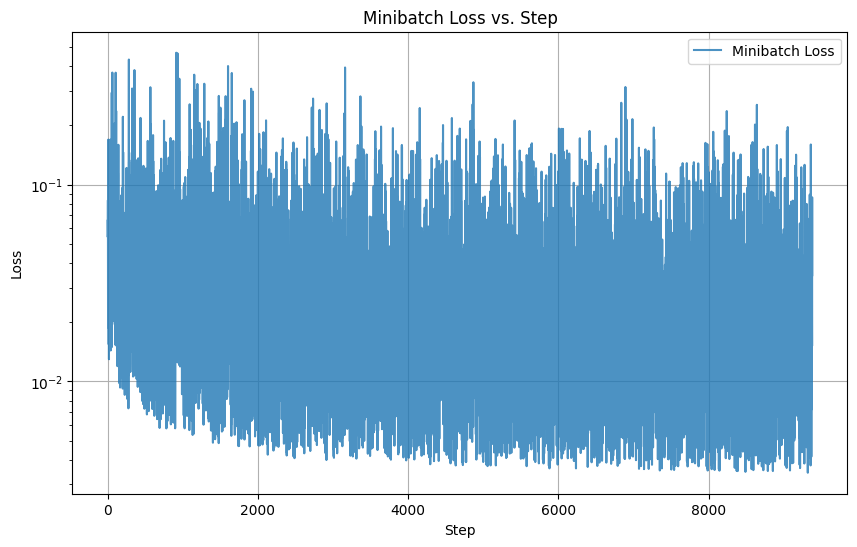

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, label='Minibatch Loss', alpha=0.8)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Minibatch Loss vs. Step')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
clean_test_images, _ = next(iter(time_cond_test_loader))
# clean_test_images = clean_test_images[:16]
batch_size = clean_test_images.shape[0]

# clean_test_display = [img.permute(1, 2, 0).cpu() / 2. + 0.5 for img in clean_test_images]

# mediapy.show_images(
#         clean_test_display,
#         columns=4,  # Show 4 images per row
#         height=200  # Height of each image
#     )

num_ts = 300

x_T = torch.randn_like(clean_test_images) # x_T is pure noise

z = torch.zeros_like(clean_test_images).cuda()
x_t = x_T.cuda()
t_tensor = torch.empty(batch_size, dtype=torch.float32, device='cuda')

with torch.no_grad():
  for t in range(num_ts - 1, 0, -1): # goes from 299 to 1 inclusive
    gc.collect()

    if t > 1:
      z.normal_()
    else:
      z.zero_()

    t_normalized = t / 300.0
    t_tensor.fill_(t_normalized)

    pred_noise = unet(x_t, t_tensor)

    alpha = schedule["alphas"][t]
    beta = schedule["betas"][t]
    alpha_bar = schedule["alpha_bars"][t]
    next_alpha_bar = schedule["alpha_bars"][t - 1]

    pred_clean_coeff = (beta * math.sqrt(next_alpha_bar)) / (1 - alpha_bar)

    x_t_coeff = (math.sqrt(alpha) * (1 - next_alpha_bar)) / (1 - alpha_bar)

    variance_coeff = math.sqrt(beta)

    pred_clean = (1 / math.sqrt(alpha_bar)) * (x_t - (math.sqrt(1 - alpha_bar) * pred_noise))

    x_t = (pred_clean_coeff * pred_clean) + (x_t_coeff * x_t) + (variance_coeff * z)

    del pred_noise, pred_clean
    torch.cuda.empty_cache()

denoised_display = [img.permute(1, 2, 0).cpu() / 2. + 0.5 for img in x_t]

mediapy.show_images(
        denoised_display,
        columns=4,  # Show 4 images per row
        height=200  # Height of each image
    )

,,,
,,,
,,,
,,,
,,,
,,,
,,,
,,,
,,,
,,,
,,,


In [ ]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()

    epsilon = torch.randn_like(x_0)
    t = random.randint(0, num_ts - 1)

    alpha_bar = ddpm_schedule["alpha_bars"][t]
    x_t = (math.sqrt(alpha_bar) * x_0) + (math.sqrt(1 - alpha_bar) * epsilon)
    x_t = x_t.cuda()

    optimizer.zero_grad()
    t = t / num_ts
    t_tensor = torch.tensor([t] * 128, dtype=torch.float32)
    t_tensor = t_tensor.cuda()

    outputs = unet(x_t, t_tensor)

    loss = criterion(outputs, epsilon)
    loss.backward()
    optimizer.step()

    return loss